In [1]:
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, r2_score

from catboost import CatBoostRegressor, CatBoostClassifier

import nltk

# Домашняя работа

Работаем с отзывами на авиа-компанию:

https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews/data


In [2]:
df = pd.read_csv('../data/singapore_airlines_reviews.csv')
df = df[['rating', 'text', 'title']]
df.head()

,rating,text,title
0,3,We used this airline to go from Singapore to L...,Ok
1,5,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...
2,1,"Booked, paid and received email confirmation f...",Don’t give them your money
3,5,"Best airline in the world, seats, food, servic...",Best Airline in the World
4,2,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...




## Easy

Выбрать метрику.

Удалить пунктуацию из датасета.

Преобразовать датасет в BOW или TF-IDF, поделить на треин-тест и спрогнозировать вашей любимой моделью


In [3]:
def pre_process(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join(text.split())
    return text

df['text'] = df['text'].apply(str).apply(pre_process)
df['title'] = df['title'].apply(str).apply(pre_process)
df.head()

,rating,text,title
0,3,we used this airline to go from singapore to l...,ok
1,5,the service on singapore airlines suites class...,the service in suites class makes one feel lik...
2,1,booked paid and received email confirmation fo...,don’t give them your money
3,5,best airline in the world seats food service a...,best airline in the world
4,2,premium economy seating on singapore airlines ...,premium economy seating on singapore airlines ...


In [4]:
# можно было бы сделать ансабль моделей для оценки текста и заголовка по отдельности, но видимо задание этого не подразумевает, поэтому просто соединим
df['text'] = df['title'] + ' ' + df['text']
df = df[['rating', 'text']]

In [5]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df['text'], df['rating'], train_size=0.8, random_state=113)
 
tfid = TfidfVectorizer()
x_train = tfid.fit_transform(x_train_raw).toarray()
x_test = tfid.transform(x_test_raw).toarray()

Text(0.5, 0, 'rating')

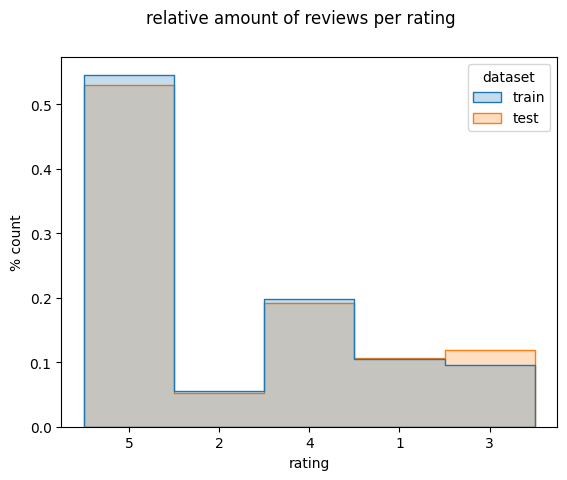

In [6]:
plt.suptitle('relative amount of reviews per rating')

df_extra = pd.concat([
    pd.DataFrame({'rating': y_train.astype(str), 'dataset': 'train'}),
    pd.DataFrame({'rating': y_test.astype(str), 'dataset': 'test'})
])

sns.histplot(
    df_extra,
    x='rating',
    hue='dataset',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('rating')

Классы несбалансированны, поэтому как и в задаче со знаками будем использовать f1 + LogReg (показалаа себя очень хорошо).

In [7]:
max_iter = 50
n_jobs = 12

In [8]:
%%time

model_LR = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs, random_state=113)
model_LR.fit(x_train, y_train)

CPU times: total: 1.08 s
Wall time: 18 s


LogisticRegression(max_iter=50, n_jobs=12, random_state=113)

In [9]:
def show_model_perfection_metrics(y_test, y_pred):
    print(f1_score(y_test, y_pred, average='weighted'))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def show_regression_model_perfection_metrics(y_test, y_pred):
    print(r2_score(y_test, y_pred))

    plt.figure(figsize=(16, 16))
    sns.histplot(y_test - y_pred, kde=True)
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.show()

0.6512139671797964


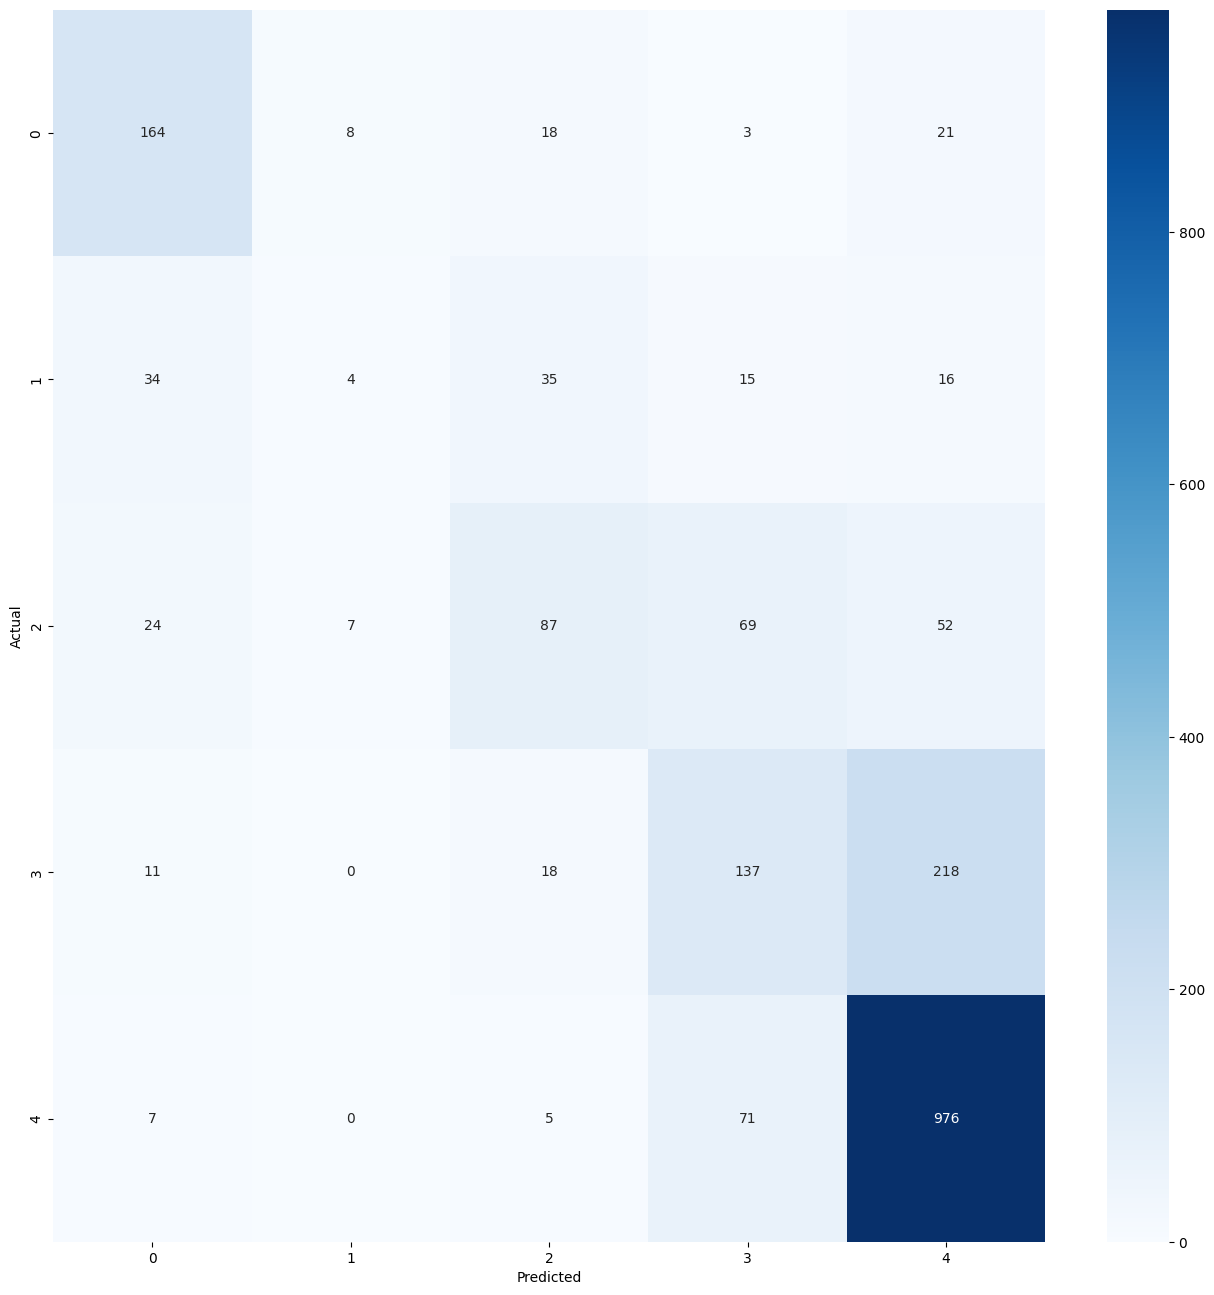

In [10]:
show_model_perfection_metrics(y_test, model_LR.predict(x_test))

Как и ожидалось, модель склонна к завышению оценки (ибо положительные отзывы - это самый мощный класс).


## Normal

Удалить стоп-слова, применить стемминг/лемматизацию. Обучить несколько моделей, подобрать параметры, сделать выводы.

Написать самостоятельно два отзыва - один положительный, один негативный, посмотреть, угадает ли модель.

In [11]:
nltk.download('wordnet')
nltk.download("omw-1.4")

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(word):
    word = lemmatizer.lemmatize(word, pos="v")
    word = lemmatizer.lemmatize(word, pos="a")
    word = lemmatizer.lemmatize(word, pos="r")
    word = lemmatizer.lemmatize(word, pos="n")
    return word

def remorph(text):
    return ' '.join([lemmatize(word) for word in text.split()])

df['text'] = df['text'].apply(remorph)
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,rating,text
0,3,ok we use this airline to go from singapore to...
1,5,the service in suit class make one feel like v...
2,1,don’t give them your money book pay and receiv...
3,5,best airline in the world best airline in the ...
4,2,premium economy seat on singapore airline not ...


In [12]:
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

df['text'] = df['text'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating,text
0,3,ok use airline go singapore london heathrow is...
1,5,service suit class make one feel like vip serv...
2,1,don’t give money book pay receive email confir...
3,5,best airline world best airline world seat foo...
4,2,premium economy seat singapore airline worth m...


In [13]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df['text'], df['rating'], train_size=0.8, random_state=113)
 
tfid = TfidfVectorizer()
x_train = tfid.fit_transform(x_train_raw).toarray()
x_test = tfid.transform(x_test_raw).toarray()

y_train_float = y_train.astype(float)
y_test_float = y_test.astype(float)

0.6408549034833019


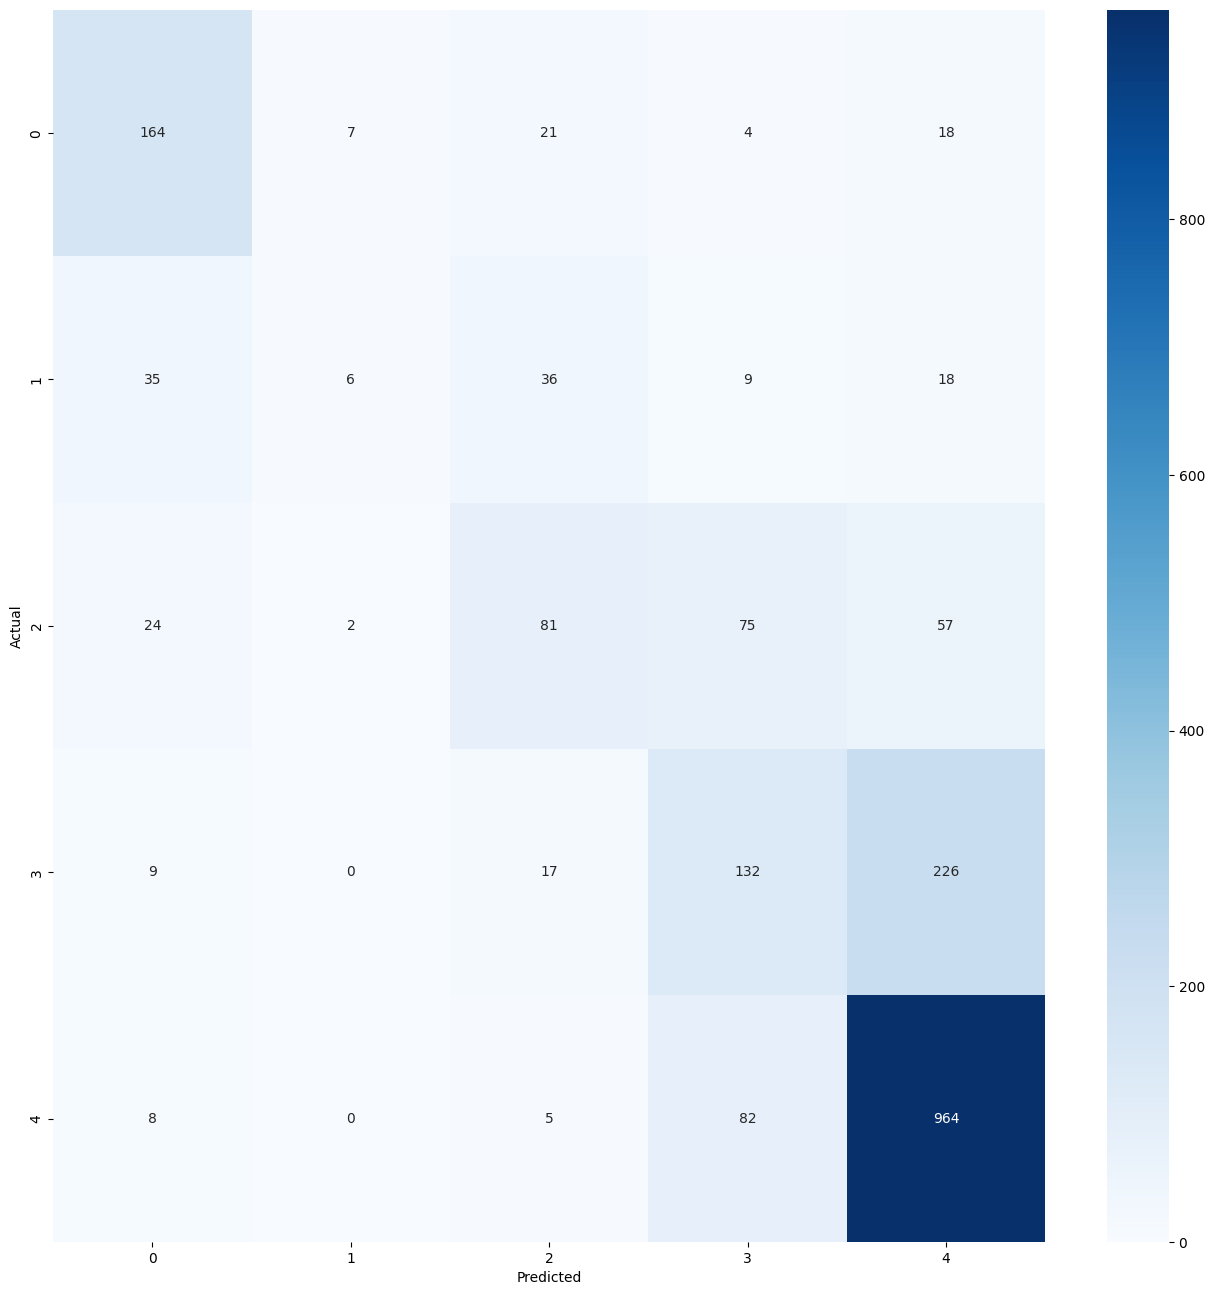

CPU times: total: 1.16 s
Wall time: 14.7 s


In [14]:
%%time

model_LR = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs, random_state=113)
model_LR.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_LR.predict(x_test))

In [15]:
%%time

model_CB = CatBoostClassifier(iterations=(max_iter*50), loss_function='MultiClass', verbose=False)
model_CB.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
)

show_model_perfection_metrics(y_test, model_CB.predict(x_test))

0.568092273576598


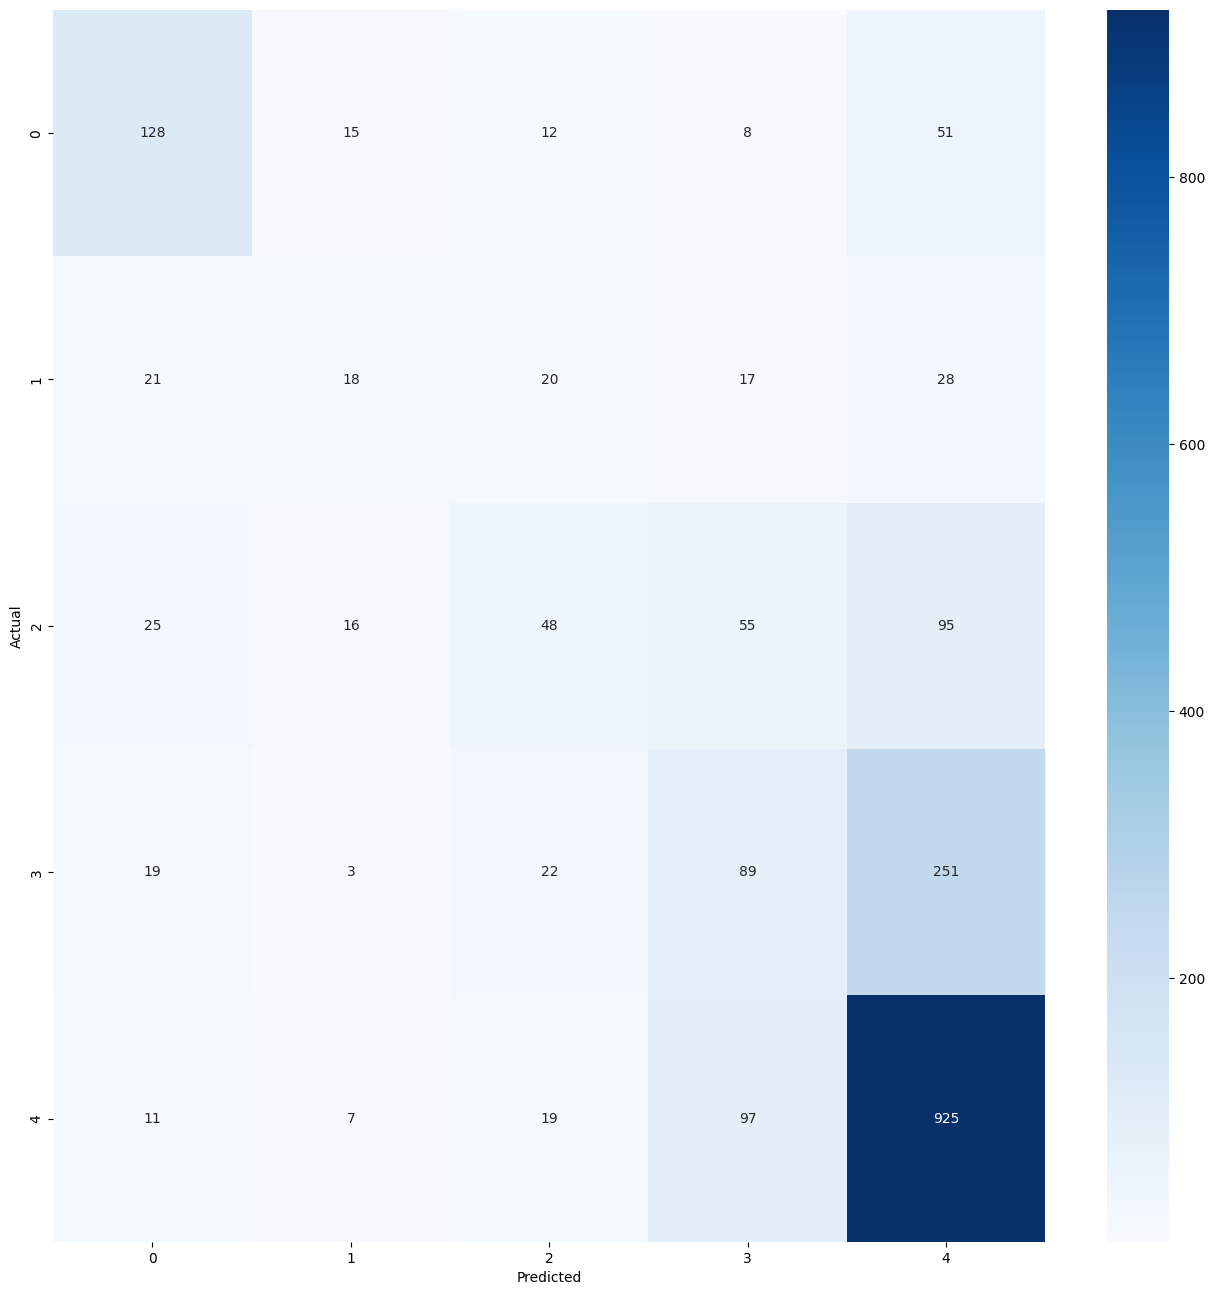

CPU times: total: 31.6 s
Wall time: 3.7 s


In [ ]:
%%time

model_knn = KNeighborsClassifier(n_neighbors=6)
model_knn.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_knn.predict(x_test))

0.5224334397953465


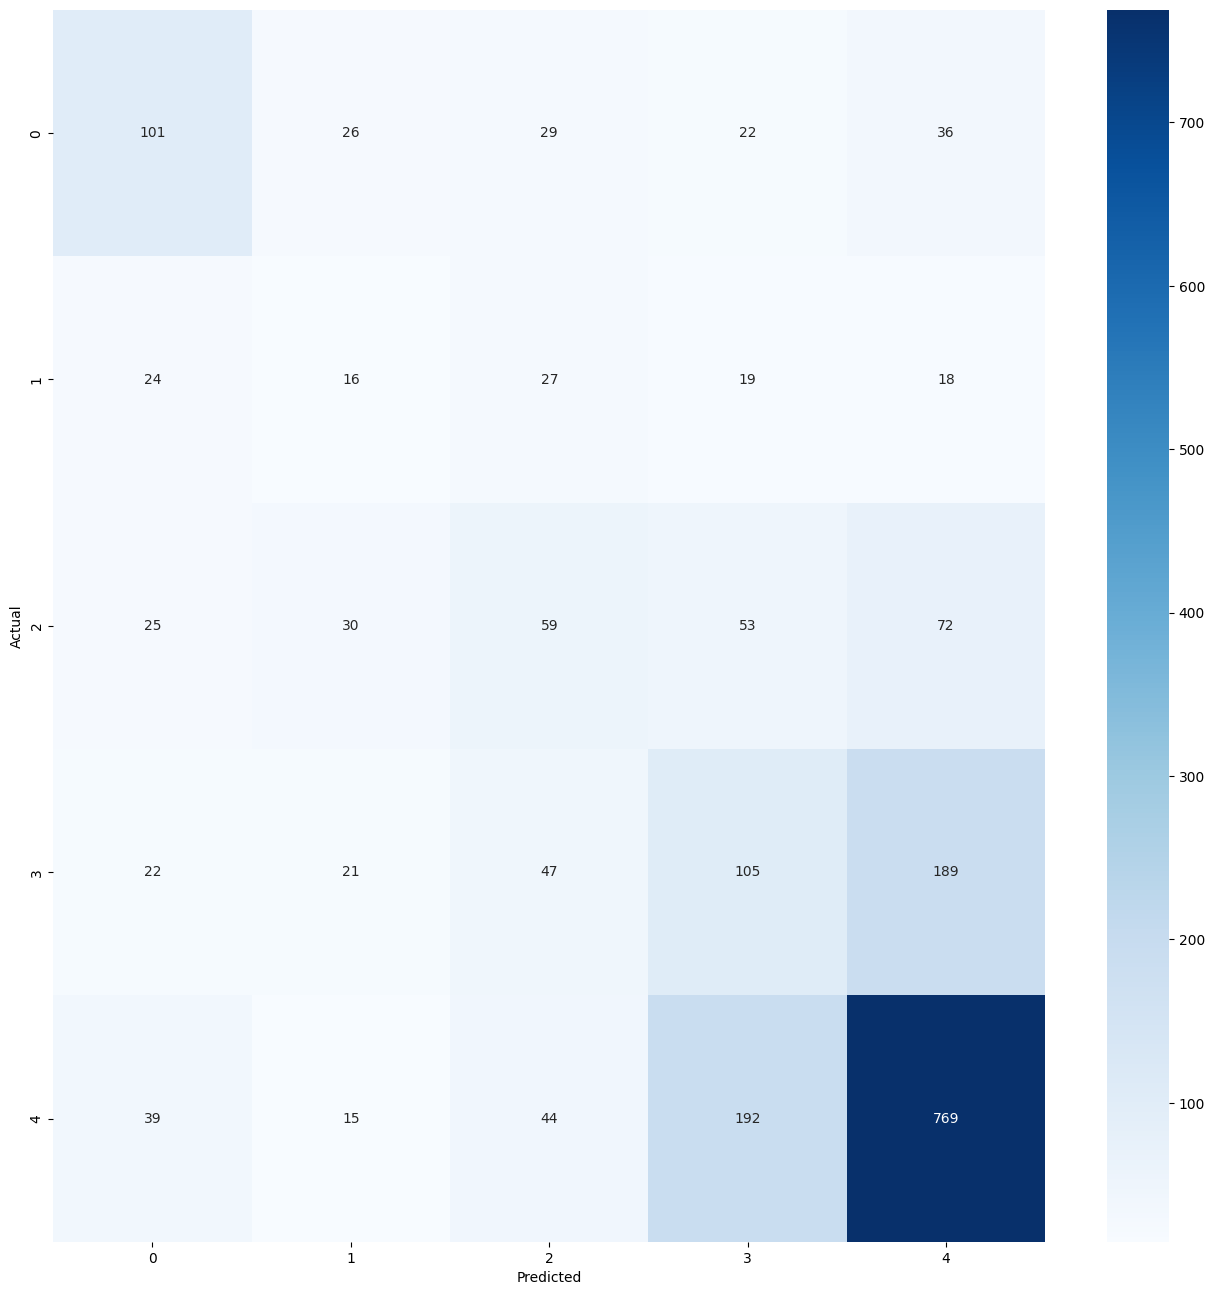

CPU times: total: 31.6 s
Wall time: 32.6 s


In [ ]:
%%time

model_DT = DecisionTreeClassifier(max_depth=100, random_state=113)
model_DT.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_DT.predict(x_test))

C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.5149160621605813


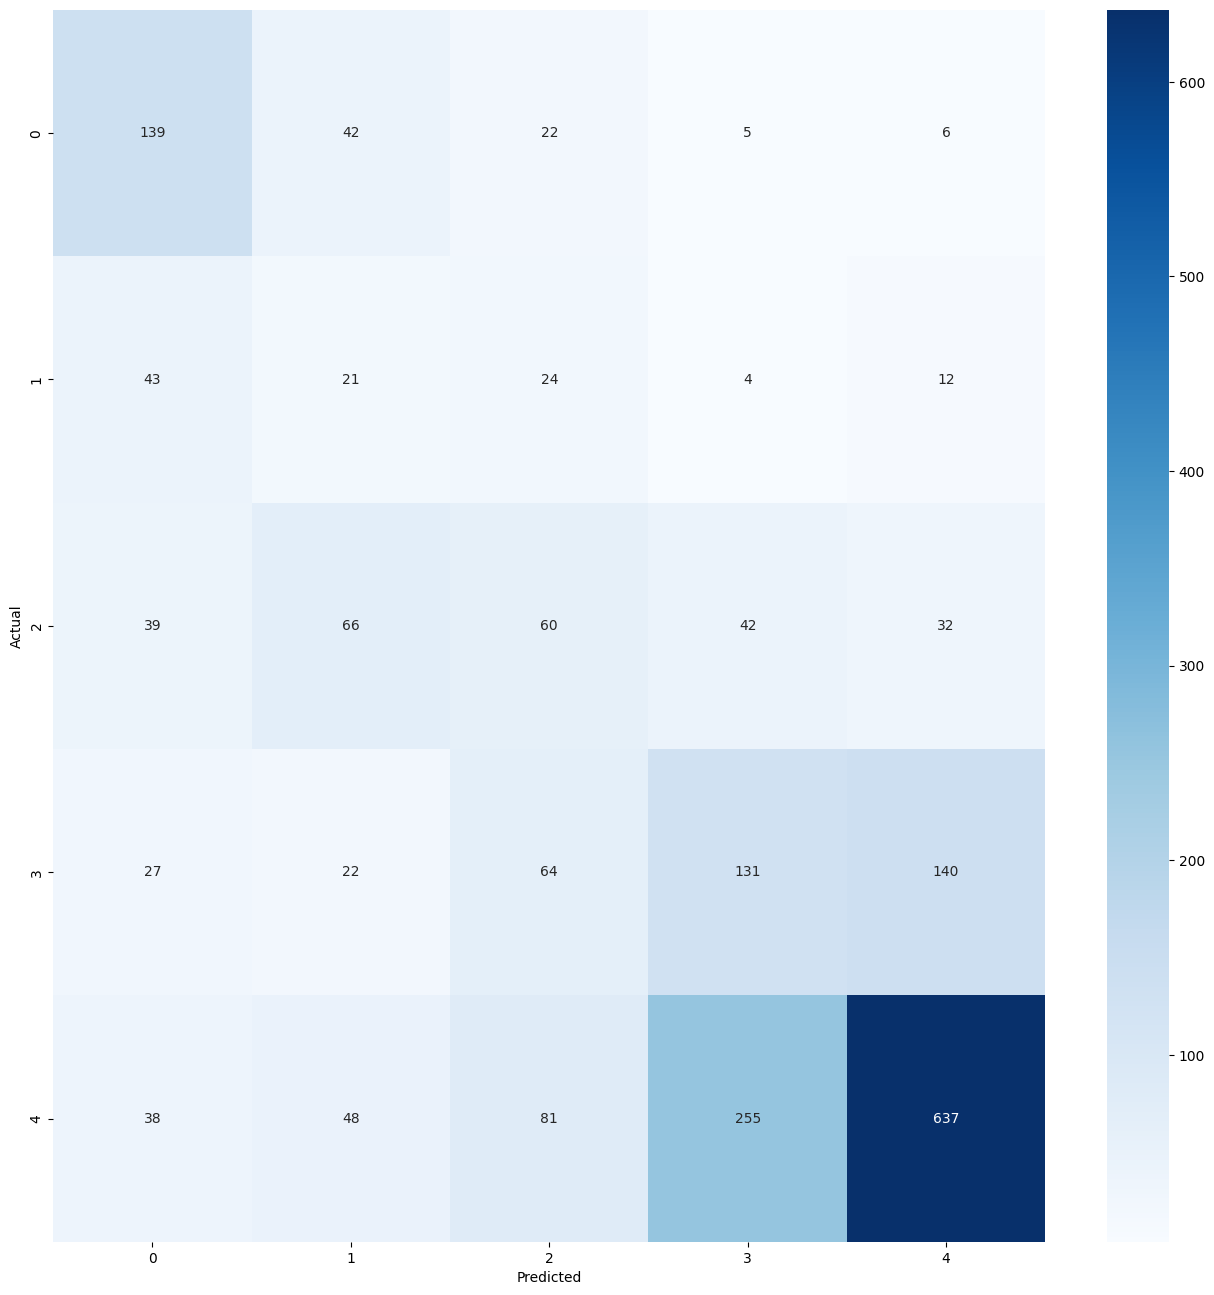

CPU times: total: 9min 29s
Wall time: 9min 48s


In [ ]:
%%time

model_SVM = SVC(kernel='rbf', max_iter=max_iter, cache_size=4000, random_state=113)
model_SVM.fit(x_train, y_train_float)

show_model_perfection_metrics(y_test_float, model_SVM.predict(x_test))

0.5856094846890412


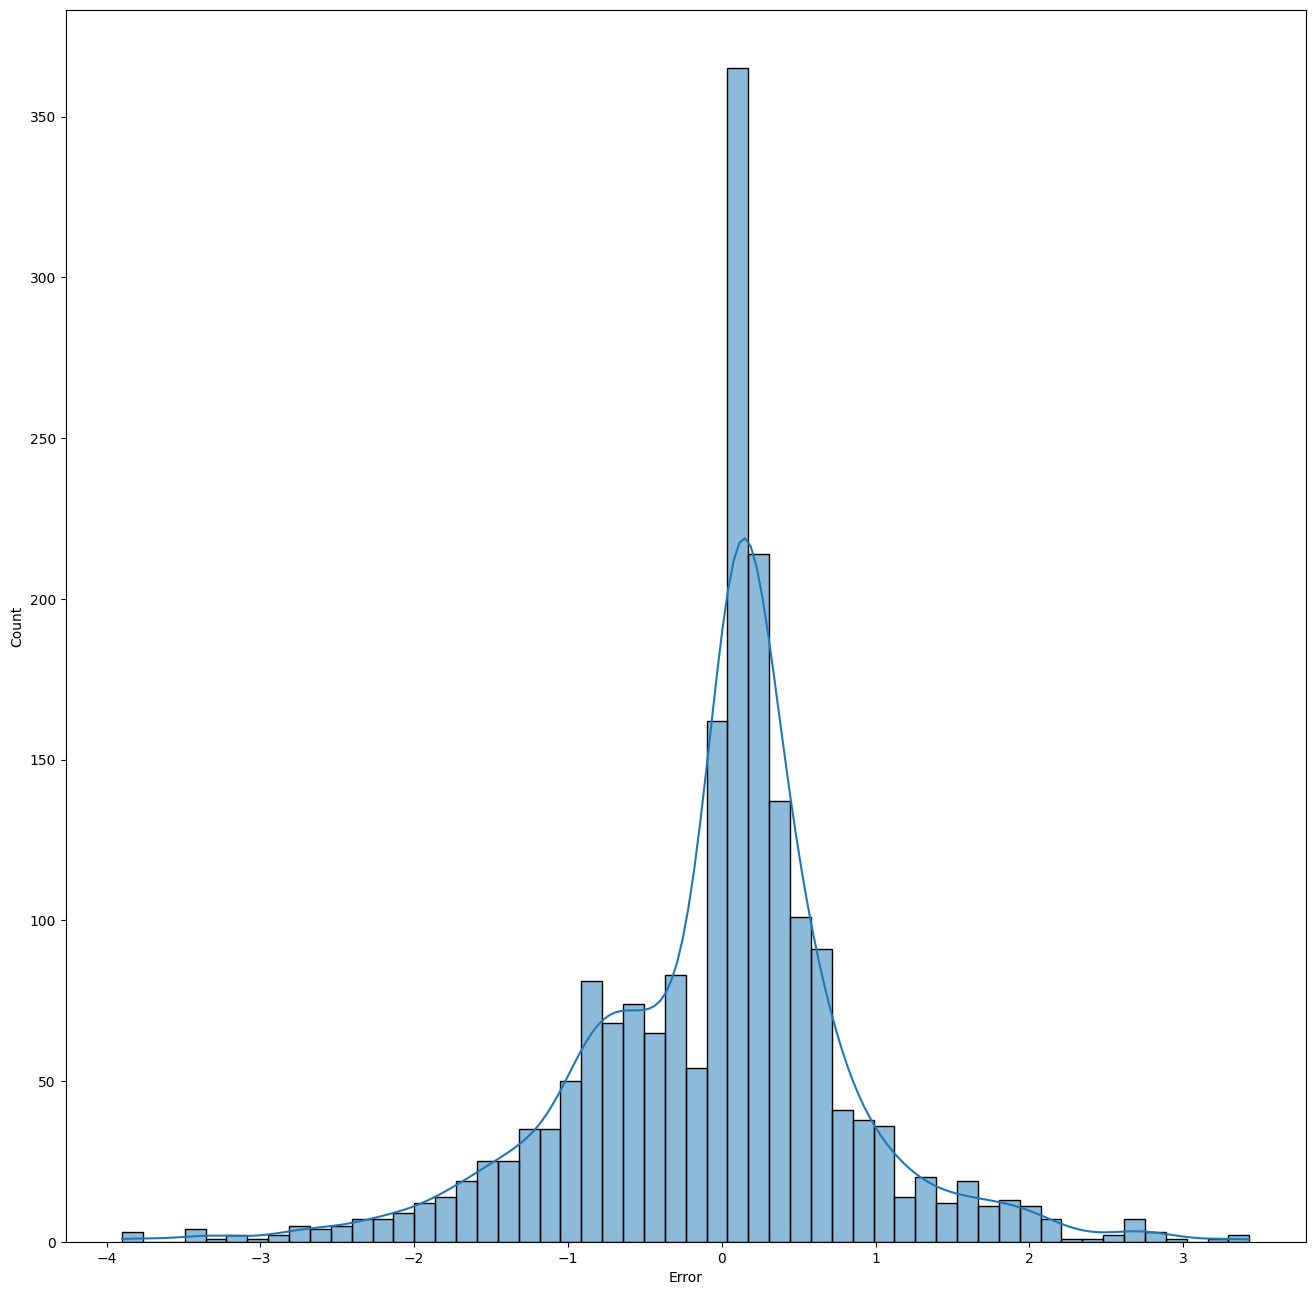

CPU times: total: 48min 11s
Wall time: 4min 18s


In [ ]:
%%time

model_RFT = RandomForestRegressor(n_jobs=n_jobs, random_state=113)
model_RFT.fit(x_train, y_train_float)

show_regression_model_perfection_metrics(y_test_float, model_RFT.predict(x_test))

Лучше всего себя показали `CatBoost` и `LogReg`. Подберём параметры для `CatBoost`.

In [ ]:
best_params = None
best_score = 0
best_model = None

support_penalty = {
    'lbfgs': ['l2'],
    'liblinear': ['l1', 'l2'],
    'newton-cg': ['l2'],
    'newton-cholesky': ['l2'],
    'sag': ['l2'],
    'saga': ['elasticnet', 'l1', 'l2']
}

for solver in ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:
    for tol in [1e-4, 1e-3, 1e-2]:
        for penalty in support_penalty[solver]:
            model = LogisticRegression(penalty=penalty, tol=tol, solver=solver, max_iter=max_iter, n_jobs=n_jobs, random_state=113)
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            f1_prec = f1_score(y_test, y_pred, average='weighted')

            print(f'penalty: {penalty}, tol: {tol}, solver: {solver} | f1: {f1_prec}')

            if f1_prec > best_score:
                best_params = {'penalty': penalty, 'tol': tol, 'solver': solver}
                best_model = LogisticRegression(penalty=penalty, tol=tol, solver=solver, max_iter=max_iter, n_jobs=n_jobs, random_state=113)

print(best_params, best_score)

C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


penalty: l1, tol: 0.0001, solver: liblinear | f1: 0.6404197354782034


C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


penalty: l2, tol: 0.0001, solver: liblinear | f1: 0.6220722437582468


C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


penalty: l1, tol: 0.001, solver: liblinear | f1: 0.6394610459818888


C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


penalty: l2, tol: 0.001, solver: liblinear | f1: 0.6220722437582468


C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


penalty: l1, tol: 0.01, solver: liblinear | f1: 0.6392517268917859


C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


penalty: l2, tol: 0.01, solver: liblinear | f1: 0.6230859478419949
penalty: l2, tol: 0.0001, solver: lbfgs | f1: 0.6349608399667267
penalty: l2, tol: 0.001, solver: lbfgs | f1: 0.6389924035049771
penalty: l2, tol: 0.01, solver: lbfgs | f1: 0.6369263687980489


KeyboardInterrupt: 

In [ ]:
model = best_model
model.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model.predict(x_test))

In [ ]:
my_reviews = [{
    'text' : 'I realy love the flight. There was no turbulence, seats were comfortable. This is definitely the best airline in the world. I will definitely fly with them again.',
    'title' : 'Best airline in the world',
    'rating' : 5
},
{
    'text' : 'I hate this airline. The flight was delayed, the seats were very narrow. But even worse attitude to the luggage. It was completely broken.',
    'title' : 'Bad airplanes with bad service',
    'rating' : 1
},
{
    'text' : 'Nothing special. The flight was normal. The choice of snacks was quite poor, but for such a short flight it is not critical. There was an advertising on every luggage compartment, but for this price it is quite normal.',
    'title' : 'Just a normal flight',
    'rating' : 3
}]

def prefactoring(text, title):
    text = title + ' ' + text
    text = pre_process(text)
    text = remorph(text)
    text = remove_stopwords(text)
    return text

x_my_reviews = tfid.transform([prefactoring(review['text'], review['title']) for review in my_reviews]).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])

Хм, довольно аккуратно.


## Hard

Исследовать какие слова полученный алгоритм воспринимает как резко-негативные и резко-позитивные. Научиться систематически обманывать классификатор. Написать 5 положительных и 5 негативных отзывов, где модель будет ошибаться. Важен алгоритм по которому вы составляете эти отзывы, а не сами отзывы.

In [ ]:
my_reviews = [
{
    'text' : 'Other companies are terrible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. But Singapore Airlines is devoid of these disadvantages. Of course, there is space to improve, but now I will only choose this company.',
    'title' : ' Other companies should learn from Singapore Airlines',
    'rating' : 4
}, # tricky case - изначально идет множество негативных вещей, но они относятся к другим компаниям, а не к Singapore Airlines. При этом, когда говорится о Singapore Airlines, для сравнения используются также негативные термины (devoid, disadvantages), несущие позитивный смысл
{
    'text' : 'It was supposed to be the best travel in my life since I haven`t traveled for almost three years. I choose the business class and it was a great decision. The service was excellent due to high expectations of service level in Singapore Airlines. But reality was much worse. The food was tasty, but was served cold. The stewardess was very polite, but she was not able to help me with my problem. The entertainment system was very good, but it was not working properly at my seat. I was very disappointed.',
    'title' : 'Disappointment',
    'rating' : 2
}, # tricky case - опять таки, много хороших слов, но все не отсносятся к Singapore Airlines, а к ожиданиям от него.
]

x_my_reviews = tfid.transform([prefactoring(review['text'], review['title']) for review in my_reviews]).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])

Хм, на первом кейсе модель показала хороший результат. Однако склонен привязать это к тому, что модель склонна завышать отзыв по рейтингу (ибо это наиболее вречающийся класс). Возможно те слова, которые были использованы просто не попали в обучающую выборку.

In [ ]:
my_reviews = [
{
    'text' : 'Other companies are terrible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. But Singapore Airlines is devoid of these disadvantages. Of course, there is space to improve, but now I will only choose this company.',
},
{
    'text' : 'Other companies are terrible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. devoid.',
},
{
    'text' : 'Other companies are terrible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. course.',
},
{
    'text' : 'Other companies are terrible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking.',
},
{
    'text' : 'Other companies are terrible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. But Singapore Airlines does not have these disadvantages. But there is space to improve.',
},
] # отличаются концовки.

x_my_reviews = tfid.transform([prefactoring(review['text'], '') for review in my_reviews]).toarray()

pred = model.predict(x_my_reviews)
print(pred)

Надо же, модель очень любит слова `devoid` и `course` (и множество других, на которые я пробовал заменить `of course`).

Итог: cуть в том, чтобы в коментарии содержались слова, имеющие без контекста противоположный смысл, при этом, избегая слов, описанных выше.

In [ ]:
print(model.importance_)

NameError: name 'model' is not defined